In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
taxi_df = pd.read_csv("taxi.csv")
taxi_lookup_df = pd.read_csv("taxi_zone_lookup.csv")
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-06-08 07:52:31,2017-06-08 08:01:32,6,1.03,1,N,161,140,1,7.5,1.0,0.5,1.86,0.0,0.3,11.16
1,2,2017-06-08 08:08:18,2017-06-08 08:14:00,6,1.03,1,N,162,233,1,6.0,1.0,0.5,2.34,0.0,0.3,10.14
2,2,2017-06-08 08:16:49,2017-06-08 15:43:22,6,5.63,1,N,137,41,2,21.5,1.0,0.5,0.00,0.0,0.3,23.30
3,1,2017-06-09 17:59:37,2017-06-09 18:04:40,1,0.60,1,N,164,234,1,5.0,1.0,0.5,1.02,0.0,0.3,7.82
4,1,2017-06-09 17:59:37,2017-06-09 18:19:26,1,2.80,1,N,229,113,1,14.5,1.0,0.5,3.25,0.0,0.3,19.55


In [5]:
rounded_trip_distance = taxi_df['trip_distance'].round(0) #trip_distance rounded to the nearest mile
dropoff = taxi_df['tpep_dropoff_datetime'].astype('datetime64[ns]')
pickup = taxi_df['tpep_pickup_datetime'].astype('datetime64[ns]')
duration = (dropoff - pickup).dt.total_seconds() #duration of the trip in seconds

new_taxi_df = pd.DataFrame()
new_taxi_df['trip_distance'] = taxi_df['trip_distance']
new_taxi_df['rounded_trip_distance'] = rounded_trip_distance
new_taxi_df['duration'] = duration

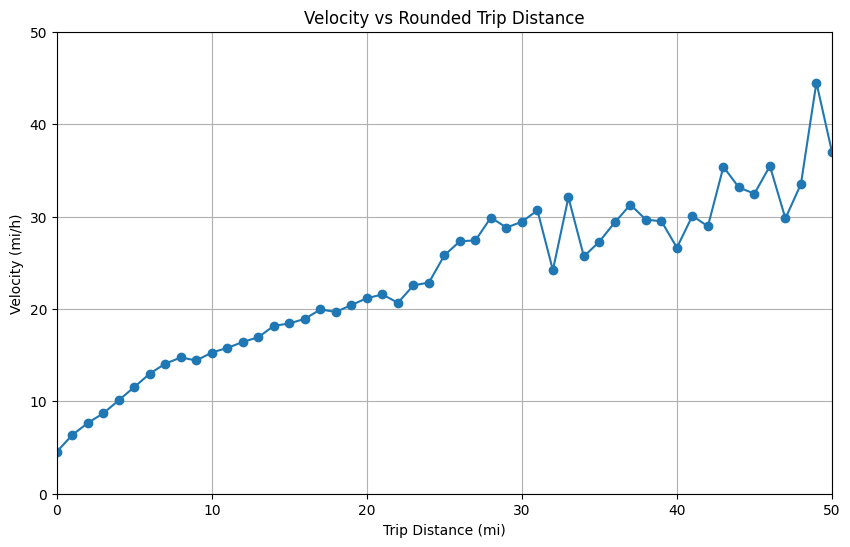

In [6]:
grouped = new_taxi_df.groupby('rounded_trip_distance').agg({
    'trip_distance': 'sum',
    'duration': 'sum'
    })
grouped['velocity'] = grouped['trip_distance'] / (grouped['duration'] / 3600)
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped['velocity'], marker='o', linestyle='-')
plt.xlabel('Trip Distance (mi)')
plt.ylabel('Velocity (mi/h)')
plt.title('Velocity vs Rounded Trip Distance')
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.grid(True)
plt.show()

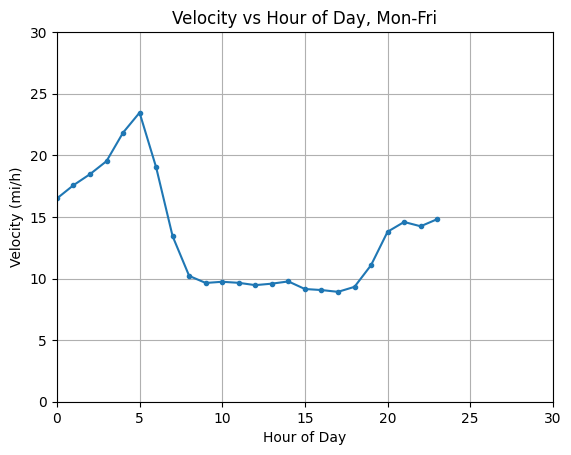

In [11]:
taxi_df['tpep_dropoff_datetime'].astype('datetime64[ns]').dt.hour
taxi_df['tpep_dropoff_datetime'].astype('datetime64[ns]').dt.dayofweek

taxi_copy = taxi_df.copy()
taxi_copy['duration'] = duration
taxi_copy['days']= taxi_df['tpep_dropoff_datetime'].astype('datetime64[ns]').dt.dayofweek
taxi_copy['hours']=taxi_df['tpep_dropoff_datetime'].astype('datetime64[ns]').dt.hour

#filtering to include weekdays only (Monday to Friday), and including only those trips whose duration is strictly less than 1 hour
taxi_copy_filtered = taxi_copy[(taxi_copy['duration']<3600) & (taxi_copy['days']<5)].groupby('hours') [['trip_distance', 'duration']].sum()
taxi_copy_filtered['velocity'] = ((taxi_copy_filtered['trip_distance'])/(taxi_copy_filtered['duration']))*3600

plt.plot(taxi_copy_filtered.index,taxi_copy_filtered['velocity'],'.-')
plt.title('Velocity vs Hour of Day, Mon-Fri')
plt.xlabel('Hour of Day')
plt.ylabel('Velocity (mi/h)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.grid(True)
plt.show()

Machine Learning Algorithm that predicts the total amount of time that a taxi trip will take so that this information can be given to the rider before they depart.

In [16]:
import statsmodels.api as sm

taxi_df['dropoff'] = taxi_df['tpep_dropoff_datetime'].astype('datetime64[ns]')
taxi_df['pickup'] = taxi_df['tpep_pickup_datetime'].astype('datetime64[ns]')

taxi_df['trip_minutes'] = (taxi_df['dropoff'] - taxi_df['pickup']).dt.total_seconds() / 60
taxi_df['hour_of_day'] = taxi_df['pickup'].dt.hour
taxi_df['trip_distance_squared'] = taxi_df['trip_distance'] ** 2
taxi_df['hour_of_day_squared'] = taxi_df['hour_of_day'] ** 2

taxi_df = taxi_df[(taxi_df['trip_distance'] >= 0.01) & (taxi_df['trip_distance'] <= 30)]
taxi_df = taxi_df[(taxi_df['trip_minutes'] >= 0.01) & (taxi_df['trip_minutes'] <= 180)]

X = taxi_df[['trip_distance', 'hour_of_day', 'trip_distance_squared', 'hour_of_day_squared']]
X = sm.add_constant(X)

y = taxi_df['trip_minutes']

model = sm.OLS(y, X).fit()

r_squared = model.rsquared
print('R squared:',r_squared)

R squared: 0.7183196335216422
